# Transfer Learning - Part 1: Feature Extraction

Transfer learning is leveraging a working models existing architecture and learned patterns for our own problem.

There are two main benefits:
* 1. Can leverage an existing neural network architecture proven to work on problems similar to our own
* 2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.


Things we'll do here:
* Introduce Transfer learning with Tensorflow
* Use a small dataset to experiment faster
* Build a transfer learning feature extraction model with Tensorflow Hub
* Use Tensorboard to track modeling experiments  and results

Other Notes:
* ImageNet has a wide variety of images we can train with
* EfficientNet architecture already works well on computer vision tasks
* We'll tune patterns/weights to our own problem
* Model performs better than from scratch

In [1]:
#Import sklearn before tensorflow
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import pathlib
import numpy as np
import random
import urllib.request
import datetime

In [2]:
print(tf.__version__), sys.version, sklearn.show_versions()

2.4.1

System:
    python: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
executable: C:\Users\timar\AppData\Local\Programs\Python\Python38\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
          pip: 21.0.1
   setuptools: 49.2.1
      sklearn: 0.24.1
        numpy: 1.19.5
        scipy: 1.6.2
       Cython: None
       pandas: 1.2.3
   matplotlib: 3.4.1
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True
C:\Users\timar\AppData\Local\Programs\Python\Python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


(None,
 '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]',
 None)

# Test for Tensorflow GPU Support

GPU setup is documented here: https://www.tensorflow.org/install/gpu

In [3]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
tf.test.gpu_device_name(), tf.config.list_physical_devices('GPU')

('/device:GPU:0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [5]:
# See if we have a GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("No GPU detected or you need to install the GPU version of tensorflow using pip install tensorflow-gpu.")

Default GPU Device:/device:GPU:0


# Downloading the Data

Get 10% of 10 food classes from food 101

* The zip file we use in this notebook [is here](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip).


In [6]:
#Setup variables for our data
if os.name == "nt":
    zip_download_file = "c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent.zip"
    zip_extract_location = "c:/temp/data/10_food_classes_10_percent/"
    data_dir = "c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent"
else:
    zip_download_file = "/home/pi/Dev/data/10_food_classes_10_percent/10_food_classes_10_percent.zip"
    zip_extract_location = "/home/pi/Dev/data/10_food_classes_10_percent/"
    data_dir = "/home/pi/Dev/data/10_food_classes_10_percent/10_food_classes_10_percent"

train_data_dir = data_dir + "/train"
test_data_dir = data_dir + "/test"

In [7]:
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded it yet
#if not os.path.isfile(zip_download_file):
#    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip -O $zip_download_file

In [8]:
# Unzip the data
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded and unzipped it yet
if not os.path.exists(data_dir):
    zip_ref = zipfile.ZipFile(zip_download_file)
    zip_ref.extractall(path=zip_extract_location)
    zip_ref.close()

In [9]:
# Walk through the data directory and list number of files
# The extra file in our data directory is .DS_Store
for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent
There are 10 directories and 0 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\ice_cream
There are 0 directorie

In [10]:
 # Another way to find out how many images are in a directory
 num_sushi_images_train = len(os.listdir(data_dir+"/train/sushi"))
 num_sushi_images_train

75

# 1. Visualize our Images

In [11]:
train_data_dir_path = pathlib.Path(train_data_dir)
for item in train_data_dir_path.glob("*"):
    print(item)

c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\chicken_curry
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\chicken_wings
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\fried_rice
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\grilled_salmon
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\hamburger
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\ice_cream
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\pizza
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\ramen
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\steak
c:\temp\data\10_food_classes_10_percent\10_food_classes_10_percent\train\sushi


In [12]:
# To visualize our imaages, first lets get our class names programatically
train_data_dir_path = pathlib.Path(data_dir+"/train/")
# Create a list of class names from the subdirectories
class_names = np.array(sorted([item.name for item in train_data_dir_path.glob("*")]))
#class_names = np.delete(class_names, np.where(class_names == ".DS_Store"))
print(class_names), len(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


(None, 10)

In [13]:
# Lets visualize our images
def view_random_images(target_dir, class_names, class_to_show=None, num_images=4, figsize=(10,10)):
    
    plt.figure(figsize=figsize)
    for i in range(num_images):
        # If a class was specified then show only that class
        if class_to_show:
            selected_class = class_to_show
        # Otherwise randomly pick classes
        else:
            selected_class = random.choice(class_names)

        # Setup the target directory (we'll view images from here)
        target_folder = target_dir + "/" + selected_class

        plt.subplot(1, num_images, i+1)

        #Get a random image path
        random_image = random.sample(os.listdir(target_folder), 1)
        
        # Read in the image and plot it using matplotlib
        img = mpimg.imread(target_folder + "/" + random_image[0])
        plt.imshow(img)
        plt.title(f"{selected_class}\nShape: {img.shape}\nFile: {random_image[0]}")
        plt.axis("off")

        print(f"Image Shape: {img.shape}")
        #return img

Image Shape: (512, 384, 3)
Image Shape: (289, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (384, 512, 3)


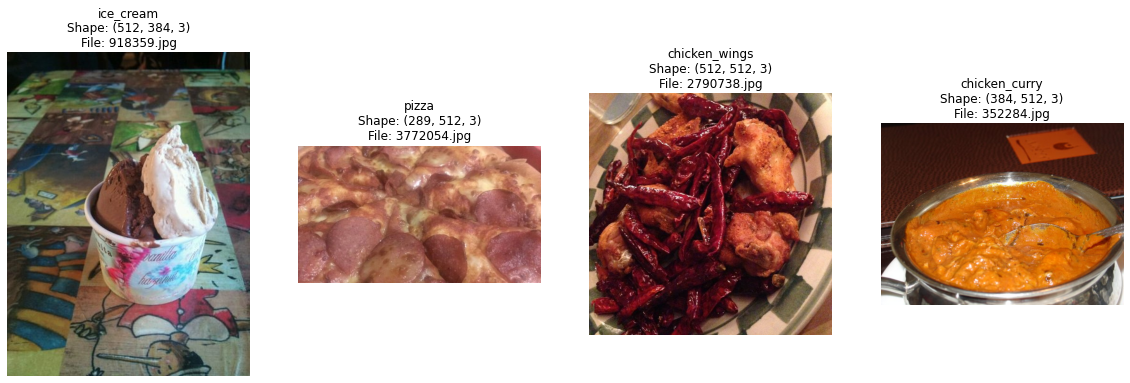

In [14]:
# View a random image from the training data set
view_random_images(
    target_dir=train_data_dir, 
    class_names = class_names,
    #Optionally pass in a specific class to show only images from that class
    #class_to_show = random.choice(class_names),
    num_images=4,
    figsize=(20,20)
)

# 2. Preprocess our Images

Our next step is to turn our data into batches and load our training and test sets.

A batch is a small subset of data. Rather than look at all ~10k images, a model might only look at 32 at a time. 

It does this for a couple of reasons:
* 10k images might not fit into the memory of the procesor
* Trying to learn the patterns in 10k images in one hit could result in the model not being able to learn very well.

Why 32?

Because 32 is good for your health per Yann Lecun. (google yann lecun batchsize, see his twitter post). Yann Lecun is a professor at NYU

In [15]:
#Constants
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Set the seed for reproducibility
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 and 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data in from directories and turn it into batches
# Setup paths to our data directories
# Use these variables extablished above
# train_data_dir
# test_data_dir

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size = BATCH_SIZE,
    # Reshape all the images to be the same size. 
    target_size = IMAGE_SHAPE,
    class_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    seed = 42
)

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    batch_size = BATCH_SIZE,
    # Reshape all the images to be the same size. 
    target_size = IMAGE_SHAPE,
    class_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    seed = 42
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [16]:
# Get a sample of train data batch
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [17]:
# How many batches are there
len(train_data) # This equals 1500 images divided by batch size of 32, rounded up

24

In [18]:
# Show a random image and its label from our Image Generator/Loader
import random
def view_random_image_from_data_generator_iterator(images, labels):
    # Return a number between 0 and the length of our images array (both included)
    random_number = random.randint(0, len(images)-1)
    label_index = np.argmax(labels[random_number])
    print(f"Showing image number {random_number}")
    image_shape = images[random_number].shape
    plt.imshow(images[random_number])
    plt.title(f"{class_names[label_index]}\nShape: {image_shape}")
    plt.axis(False)

Showing image number 6


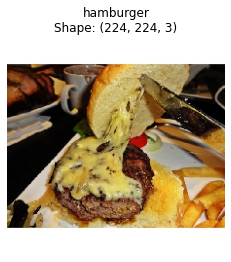

In [19]:
view_random_image_from_data_generator_iterator(images, labels)

# Setting up callbacks (things to run whilst our model trains) - Tensorboard

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with the ModelCheckpoint callbacks
* Stopping a model from training *before it trains too long and overfits) with the EarlyStopping callbac k


In [20]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir,        
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback
    

# 3. Creating models using TensorFlow Hub (RESNET)
[TensorFlow Hub](https://www.tensorflow.org/hub)

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come frokm TensorFlow Hub.

We can access pretrained models on [tfhub.dev](https://tfhub.dev/) 

Another good resource to find which model is the best for a problem domain is from [Papers with Code](https://paperswithcode.com/sota)

For this notebook, we will use this pretrained model: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
and this model: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4



In [21]:
# Lets compare the following 2 models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [22]:
import tensorflow_hub as hub
# Lets make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a tensorflow hub url and creates a keras sequential model with it.
    Args:
        model_url (str): A tensorflow hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer, should be equal to number of
        target classes,default 10.

    Returns:
        An uncompiled Keras sequential model with model_url as feature extractor layer and Dense output layer 
        with num_classes output neurons
    """
    # Download pretrained model and it as a keras layer
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False, # Freeze the already learned patterns
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE+(3,)
    )  
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

## Creating and testing ResNet Tensorflow Hub Sequential Model

In [23]:
#Create resent model
resnet_model = create_model(
    resnet_url, 
    num_classes=train_data.num_classes
)

#Compile resent model
resnet_model.compile (
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Create a tensorboard callback
tensorboard_callback = create_tensorboard_callback("c:/temp/data/tensorboard", "resnet_1")

# Fit the model
history_resnet = resnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[tensorboard_callback]
)

Saving TensorBoard log files to: c:/temp/data/tensorboard/resnet_1/20210417-072255
Epoch 1/5
24/24 [==============================] - 19s 533ms/step - loss: 2.2172 - accuracy: 0.2316 - val_loss: 1.1250 - val_accuracy: 0.6664
Epoch 2/5
24/24 [==============================] - 5s 232ms/step - loss: 0.9649 - accuracy: 0.6986 - val_loss: 0.8263 - val_accuracy: 0.7456
Epoch 3/5
24/24 [==============================] - 5s 232ms/step - loss: 0.6462 - accuracy: 0.8111 - val_loss: 0.7396 - val_accuracy: 0.7552
Epoch 4/5
24/24 [==============================] - 5s 235ms/step - loss: 0.4649 - accuracy: 0.8762 - val_loss: 0.6902 - val_accuracy: 0.7780
Epoch 5/5
24/24 [==============================] - 6s 238ms/step - loss: 0.3707 - accuracy: 0.9336 - val_loss: 0.6621 - val_accuracy: 0.7840


In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Evaluating our Resnet Model

Review the cells below, but the summary is this model overfits.

* Note: When a models **validation loss** starts to increase it's likely that the model is **overfitting**. This means it's learning the patterns in the training dataset too well and thus the model's ability to generalize unseen data will be diminished.

In [25]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 4s 55ms/step - loss: 0.6621 - accuracy: 0.7840


[0.6621295213699341, 0.7839999794960022]

In [26]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"])) # how many epochs did we train for

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot Accuracy
    plt.figure() #Start a new plot figure
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

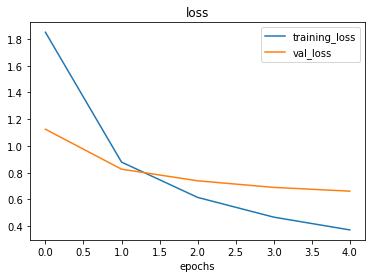

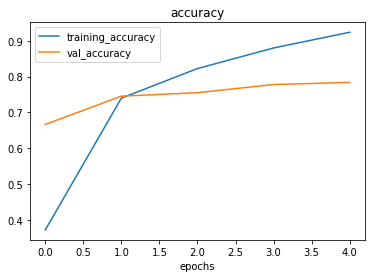

In [27]:
# Checkout the loss and accuracy of the model
# If training loss is decreasing, but validation loss is increasing, then it shows our model is overfitting.
# Ideally we'd like the curves to line up and follow each other
# In first graph the validation loss is going up after 2 epochs, so the model is overfitting (learning the training data too well). It gets great results on the training data, but it is failing to generalize well to unseen data and it performs poorly on the test data.
plot_loss_curves(history_resnet)

## Make a prediction on a test image


In [28]:
# Create a function to import our image, and resize it to be able to be used with our model
def load_and_prep_image(url, img_shape=224):
    """
    Reads an image from filename, and turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
    """
    # Read in the image
    #img = tf.io.read_file(filename)
    image_request = urllib.request.urlopen(url)
    img = image_request.read()
    # Decode the read file into a tensor
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

In [29]:
def predict_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model, and plots the image with the predicted class as the title.
    """
    #Import the target images and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    print(pred)

    # Get the predicted class
    if len(class_names) <= 2:
        # For binary:
        pred_class = class_names[int(tf.round(pred))]
    else:
        # For multiclass:
        pred_class = class_names[np.argmax(pred)]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

[[0.06396009 0.02014169 0.09518213 0.5341313  0.01739462 0.00593062
  0.00475444 0.0156273  0.17463414 0.06824365]]


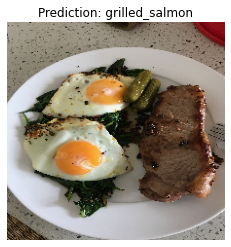

In [30]:
#Steak
predict_and_plot(resnet_model, "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg")

#predict_and_plot(resnet_model, "https://hips.hearstapps.com/del.h-cdn.co/assets/18/08/1519155106-flank-steak-horizontal.jpg")

#Pizza
#predict_and_plot(resnet_model, "https://upload.wikimedia.org/wikipedia/commons/1/10/Pepperoni_pizza.jpeg")

#Curry
#predict_and_plot(resnet_model, "https://images.squarespace-cdn.com/content/v1/57bb2e8cb3db2b9076db6369/1529609506001-AI7Y83VYPGIFN3SVU7AB/ke17ZwdGBToddI8pDm48kLkXF2pIyv_F2eUT9F60jBl7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z4YTzHvnKhyp6Da-NYroOW3ZGjoBKy3azqku80C789l0iyqMbMesKd95J-X4EagrgU9L3Sa3U8cogeb0tjXbfawd0urKshkc5MgdBeJmALQKw/AdobeStock_142271660.jpeg")

## Creating and testing EficientNet Tensorflow Hub Sequential Model

In [31]:
#Create model
efficientnet_model = create_model(
    efficientnet_url, 
    num_classes=train_data.num_classes
)

#Compile model
efficientnet_model.compile (
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Create a tensorboard callback
tensorboard_callback = create_tensorboard_callback("c:/temp/data/tensorboard", "efficientnet_1")

# Fit the model
history_efficientnet = efficientnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[tensorboard_callback]
)

Saving TensorBoard log files to: c:/temp/data/tensorboard/efficientnet_1/20210417-072407
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 2.0475 - accuracy: 0.2991 - val_loss: 1.2861 - val_accuracy: 0.7448
Epoch 2/5
24/24 [==============================] - 6s 242ms/step - loss: 1.1611 - accuracy: 0.7553 - val_loss: 0.8616 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 6s 239ms/step - loss: 0.7328 - accuracy: 0.8478 - val_loss: 0.6921 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 6s 253ms/step - loss: 0.5939 - accuracy: 0.8711 - val_loss: 0.6053 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 6s 251ms/step - loss: 0.4854 - accuracy: 0.9081 - val_loss: 0.5543 - val_accuracy: 0.8648


In [32]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Evaluating our EfficientNet Model

Review the cells below, but the summary is this model overfits.

* Note: When a models **validation loss** starts to increase it's likely that the model is **overfitting**. This means it's learning the patterns in the training dataset too well and thus the model's ability to generalize unseen data will be diminished.

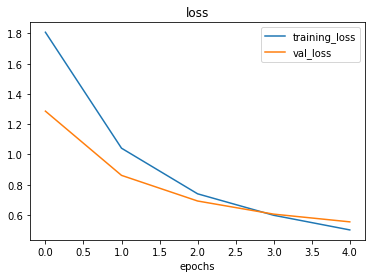

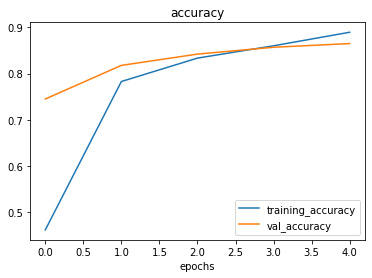

In [33]:
# Checkout the loss and accuracy of the model
# If training loss is decreasing, but validation loss is increasing, then it shows our model is overfitting.
# Ideally we'd like the curves to line up and follow each other
# In first graph the validation loss is going up after 2 epochs, so the model is overfitting (learning the training data too well). It gets great results on the training data, but it is failing to generalize well to unseen data and it performs poorly on the test data.
plot_loss_curves(history_efficientnet)

[[0.02999069 0.03619025 0.04905662 0.15744136 0.00995636 0.00759139
  0.00167737 0.01218399 0.63960266 0.05630921]]


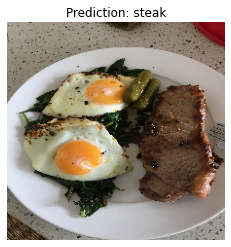

In [38]:
#Steak
predict_and_plot(efficientnet_model, "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg")

#predict_and_plot(efficientnet_model, "https://hips.hearstapps.com/del.h-cdn.co/assets/18/08/1519155106-flank-steak-horizontal.jpg")

#Pizza
#predict_and_plot(efficientnet_model, "https://upload.wikimedia.org/wikipedia/commons/1/10/Pepperoni_pizza.jpeg")

#Curry
#predict_and_plot(efficientnet_model, "https://images.squarespace-cdn.com/content/v1/57bb2e8cb3db2b9076db6369/1529609506001-AI7Y83VYPGIFN3SVU7AB/ke17ZwdGBToddI8pDm48kLkXF2pIyv_F2eUT9F60jBl7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z4YTzHvnKhyp6Da-NYroOW3ZGjoBKy3azqku80C789l0iyqMbMesKd95J-X4EagrgU9L3Sa3U8cogeb0tjXbfawd0urKshkc5MgdBeJmALQKw/AdobeStock_142271660.jpeg")

# Different types of transfer learning

* 1. As is transfer learning - using an existing model with no changes whatsoever (eg using imagenet model on 1000 imagenet classes, none of your own)
* 2. Feature extraction transfer learning - using the prelearned patterns of an existing model (eg EfficientNetB0 trained on Image Net) and adjust the output layer for your own problem (ex 1000 classes for efficient net, trained to 10 of our own classes)
* 3. Fine Tuning Learning - use the prelearned paterns of an existing mode and fine tune many or all of the underlying layers (including new output layers)


# Comparing our Models Results Using Tensorboard

Tensorboard.dev lets you easily host, track and view our results.
Note that when you upload things to tensorboard.dev, your experiments are public. If you are running private experiments, do not upload to TensorBoard.dev

To setup tensorboard locally do this :
* pip3 install -U tensorboard
* specify the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY` environment variable.
> set TENSORBOARD_BINARY=C:\Users\timar\AppData\Roaming\Python\Python38\Scripts\tensorboard.exe
* Also put that folder in the PATH
> set PATH=%PATH%;C:\Users\timar\AppData\Roaming\Python\Python38\Scripts\
* Example to launch from command line:
> C:\Users\timar\AppData\Roaming\Python\Python38\Scripts\tensorboard.exe --logdir=C:/Temp/data/tensorboard/



In [35]:
%load_ext tensorboard
# %reload_ext tensorboard


In [36]:
%tensorboard --logdir=C:/Temp/data/tensorboard/
#%tensorboard --logdir=C:/Temp/data/tensorboard/efficientnet_1

Reusing TensorBoard on port 6006 (pid 43400), started 2 days, 0:12:37 ago. (Use '!kill 43400' to kill it.)

In [37]:
from IPython.display import IFrame
IFrame('http://localhost:6006', width=700, height=350)